# Goal

* Primer design for clade of interest

# Var

In [55]:
base_dir = '/ebio/abt3_projects/software/dev/ll_pipelines/llprimer/experiments/HMP_most-wanted/'
clade = 'Prevotella'
taxid = 838
domain = 'Bacteria'

# Init

In [76]:
library(dplyr)
library(tidyr)
library(data.table)
library(tidytable)
library(ggplot2)
library(LeyLabRMisc)

In [57]:
df.dims()
work_dir = file.path(base_dir, clade)
make_dir(work_dir)

Directory already exists: /ebio/abt3_projects/software/dev/ll_pipelines/llprimer/experiments/HMP_most-wanted//Prevotella 


# Genome download

* Downloading genomes from NCBI

```
OUTDIR=/ebio/abt3_projects/software/dev/ll_pipelines/llprimer/experiments/HMP_most-wanted//Prevotella/
mkdir -p $OUTDIR
ncbi-genome-download -p 12 -s genbank -F fasta --genera /Prevotella -o $OUTDIR bacteria
```

# Genome quality

* Filtering genomes by quality

In [58]:
D = file.path(base_dir, clade, 'genbank')
files = list_files(D, '.fna.gz')
samps = data.frame(Name = files %>% as.character %>% basename,
                   Fasta = files,
                   Domain = domain,
                   Taxid = taxid) %>%
    mutate(Name = gsub('\\.fna\\.gz$', '', Name),
           Fasta = gsub('/+', '/', Fasta))
samps

# writing file
outfile = file.path(D, 'samples.txt')
write_table(samps, outfile)

Name,Fasta,Domain,Taxid
<chr>,<chr>,<fct>,<dbl>
GCA_000025925.1_ASM2592v1_genomic,/ebio/abt3_projects/software/dev/ll_pipelines/llprimer/experiments/HMP_most-wanted/Prevotella/genbank/bacteria/GCA_000025925.1/GCA_000025925.1_ASM2592v1_genomic.fna.gz,Bacteria,838
GCA_000142965.1_ASM14296v1_genomic,/ebio/abt3_projects/software/dev/ll_pipelines/llprimer/experiments/HMP_most-wanted/Prevotella/genbank/bacteria/GCA_000142965.1/GCA_000142965.1_ASM14296v1_genomic.fna.gz,Bacteria,838
⋮,⋮,⋮,⋮
GCA_902399905.1_UHGG_MGYG-HGUT-03697_genomic,/ebio/abt3_projects/software/dev/ll_pipelines/llprimer/experiments/HMP_most-wanted/Prevotella/genbank/bacteria/GCA_902399905.1/GCA_902399905.1_UHGG_MGYG-HGUT-03697_genomic.fna.gz,Bacteria,838
GCA_902794455.1_Rumen_uncultured_genome_RUG13974_genomic,/ebio/abt3_projects/software/dev/ll_pipelines/llprimer/experiments/HMP_most-wanted/Prevotella/genbank/bacteria/GCA_902794455.1/GCA_902794455.1_Rumen_uncultured_genome_RUG13974_genomic.fna.gz,Bacteria,838


File written: /ebio/abt3_projects/software/dev/ll_pipelines/llprimer/experiments/HMP_most-wanted//Prevotella/genbank/samples.txt 


### LLG

#### Config

In [7]:
cat_file(file.path(work_dir, 'config_llg.yaml'))

# table with genome --> fasta_file information
samples_file: /ebio/abt3_projects/software/dev/ll_pipelines/llprimer/experiments/HMP_most-wanted/Prevotella/genbank/samples.txt

# output location
output_dir: /ebio/abt3_projects/software/dev/ll_pipelines/llprimer/experiments/HMP_most-wanted/Prevotella/LLG_output/

# temporary file directory (your username will be added automatically)
tmp_dir: /ebio/abt3_scratch/

# batch processing of genomes for certain steps
## increase to better parallelize
batches: 2 

# Domain of genomes ('Archaea' or 'Bacteria)
## Use "Skip" if provided as a "Domain" column in the genome table
Domain: Skip

# software parameters
# Use "Skip" to skip any of these steps. If no params for rule, use ""
# dRep MAGs are not further analyzed, but you can de-rep & then use the de-rep genome table as input.
params:
  ionice: -c 3
  # assembly assessment
  seqkit: ""
  quast: Skip #""
  multiqc_on_quast: "" 
  checkm: ""
  # de-replication (requires checkm)
  drep: -comp 90 -

#### Run

```
(snakemake) @ rick:/ebio/abt3_projects/software/dev/ll_pipelines/llg
$ screen -L -S llg ./snakemake_sge.sh /ebio/abt3_projects/software/dev/ll_pipelines/llprimer/experiments/HMP_most-wanted/Prevotella/config_llg.yaml 20 -F
```

### Outlier genomes

In [109]:
mash = file.path(work_dir, 'LLG_output', 'drep', 'drep', 'data_tables', 'Mdb.csv') %>%
    Fread(sep=',') 
mash

genome1,genome2,dist,similarity
<chr>,<chr>,<dbl>,<dbl>
GCA_000613365.1_ASM61336v1_genomic.fna,GCA_000613365.1_ASM61336v1_genomic.fna,0,1
GCA_000437535.1_MGS629_genomic.fna,GCA_000613365.1_ASM61336v1_genomic.fna,1,0
⋮,⋮,⋮,⋮
GCA_900454835.1_52295_A01_genomic.fna,GCA_900108375.1_IMG-taxon_2596583684_annotated_assembly_genomic.fna,0.295981,0.704019
GCA_900108375.1_IMG-taxon_2596583684_annotated_assembly_genomic.fna,GCA_900108375.1_IMG-taxon_2596583684_annotated_assembly_genomic.fna,0.000000,1.000000


In [110]:
tmp1 = mash %>%
    summarize.(mean_dist = mean(dist), by=c(genome1)) %>%
    rename.('genome' = genome1)
tmp2 = mash %>%
    summarize.(mean_dist = mean(dist), by=c(genome2)) %>%
    rename.('genome' = genome2)
mash_s = rbind(tmp1, tmp2) %>%
    distinct(genome, mean_dist)
tmp1 = tmp2 = NULL
mash_s

genome,mean_dist
<chr>,<dbl>
GCA_000613365.1_ASM61336v1_genomic.fna,0.4467935
GCA_000437535.1_MGS629_genomic.fna,0.6066792
⋮,⋮
GCA_900454835.1_52295_A01_genomic.fna,0.3697412
GCA_900108375.1_IMG-taxon_2596583684_annotated_assembly_genomic.fna,0.4674060


In [111]:
df.dims(20)
mash_s %>%
    arrange.(-mean_dist) %>%
    slice_head.(20)
df.dims()

genome,mean_dist
<chr>,<dbl>
GCA_000431215.1_MGS1031_genomic.fna,0.9724018
GCA_002409785.1_ASM240978v1_genomic.fna,0.9617474
GCA_002449845.1_ASM244984v1_genomic.fna,0.9471815
GCA_002297545.1_ASM229754v1_genomic.fna,0.9446638
GCA_015256945.1_ASM1525694v1_genomic.fna,0.9425318
GCA_000438115.1_MGS617_genomic.fna,0.9334457
GCA_000436235.1_MGS873_genomic.fna,0.9288424
GCA_000437495.1_MGS485_genomic.fna,0.9251054
GCA_000431275.1_MGS755_genomic.fna,0.9219295


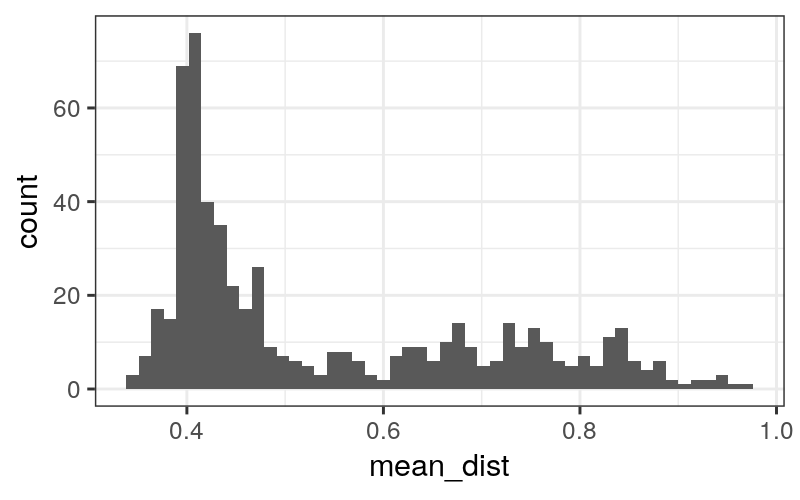

In [112]:
# plotting distribution
p = mash_s %>% 
    ggplot(aes(mean_dist)) +
    geom_histogram(bins=50) +
    theme_bw()
p.dims(4,2.5)
plot(p)

In [113]:
to_rm = mash_s %>%
    filter.(mean_dist > 0.6) %>%
    mutate.(genome = gsub('\\.fna$', '', genome)) %>%
    pull.(genome)
to_rm %>% length

[1] 197

### Samples table of high-quality genomes

In [114]:
# checkM summary
checkm = file.path(work_dir, 'LLG_output', 'checkM', 'checkm_qa_summary.tsv') %>%
    read.delim(sep='\t') 
checkm

Bin.Id,Marker.lineage,X..genomes,X..markers,X..marker.sets,Completeness,Contamination,Strain.heterogeneity,Genome.size..bp.,X..ambiguous.bases,⋯,X0,X1,X2,X3,X4,X5.,assembly.Id,assembler.Id,taxon.Id,File
<fct>,<fct>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<lgl>,<fct>
GCA_000025925.1_ASM2592v1_genomic,o__Bacteroidales (UID2716),92,486,270,99.63,0.37,100,3619559,0,⋯,1,484,1,0,0,0,|ebio|abt3_projects|software|dev|ll_pipelines|llprimer|experiments|HMP_most-wanted|Prevotella|LLG_output|checkM|1|checkm|markers_qa_summary.tsv.1,markers_qa_summary.tsv.1,NA,/ebio/abt3_projects/software/dev/ll_pipelines/llprimer/experiments/HMP_most-wanted/Prevotella/LLG_output/checkM/1/checkm/markers_qa_summary.tsv.1
GCA_000144405.1_ASM14440v1_genomic,g__Prevotella (UID2724),55,567,296,99.32,0.00,0,3168282,0,⋯,2,565,0,0,0,0,|ebio|abt3_projects|software|dev|ll_pipelines|llprimer|experiments|HMP_most-wanted|Prevotella|LLG_output|checkM|1|checkm|markers_qa_summary.tsv.2,markers_qa_summary.tsv.2,NA,/ebio/abt3_projects/software/dev/ll_pipelines/llprimer/experiments/HMP_most-wanted/Prevotella/LLG_output/checkM/1/checkm/markers_qa_summary.tsv.2
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
GCA_902386825.1_UHGG_MGYG-HGUT-02412_genomic,o__Bacteroidales (UID2657),160,492,269,97.58,0.00,0.00,3475353,3078,⋯,7,485,0,0,0,0,|ebio|abt3_projects|software|dev|ll_pipelines|llprimer|experiments|HMP_most-wanted|Prevotella|LLG_output|checkM|2|checkm|markers_qa_summary.tsv.459,markers_qa_summary.tsv.459,NA,/ebio/abt3_projects/software/dev/ll_pipelines/llprimer/experiments/HMP_most-wanted/Prevotella/LLG_output/checkM/2/checkm/markers_qa_summary.tsv.459
GCA_902399905.1_UHGG_MGYG-HGUT-03697_genomic,g__Prevotella (UID2724),55,567,296,98.14,1.46,28.57,3900702,818,⋯,7,553,7,0,0,0,|ebio|abt3_projects|software|dev|ll_pipelines|llprimer|experiments|HMP_most-wanted|Prevotella|LLG_output|checkM|2|checkm|markers_qa_summary.tsv.460,markers_qa_summary.tsv.460,NA,/ebio/abt3_projects/software/dev/ll_pipelines/llprimer/experiments/HMP_most-wanted/Prevotella/LLG_output/checkM/2/checkm/markers_qa_summary.tsv.460


In [115]:
# dRep summary
drep = file.path(work_dir, 'LLG_output', 'drep', 'checkm_markers_qa_summary.tsv') %>%
    read.delim(sep='\t') %>%
    mutate(Bin.Id = gsub('.+/', '', genome),
           Bin.Id = gsub('\\.fna$', '', Bin.Id))
drep

genome,completeness,contamination,Bin.Id
<fct>,<dbl>,<dbl>,<chr>
/ebio/abt3_scratch/nyoungblut/LLG_62325884640/genomes/GCA_000025925.1_ASM2592v1_genomic.fna,99.63,0.37,GCA_000025925.1_ASM2592v1_genomic
/ebio/abt3_scratch/nyoungblut/LLG_62325884640/genomes/GCA_000144405.1_ASM14440v1_genomic.fna,99.32,0.00,GCA_000144405.1_ASM14440v1_genomic
⋮,⋮,⋮,⋮
/ebio/abt3_scratch/nyoungblut/LLG_62325884640/genomes/GCA_902386825.1_UHGG_MGYG-HGUT-02412_genomic.fna,97.58,0.00,GCA_902386825.1_UHGG_MGYG-HGUT-02412_genomic
/ebio/abt3_scratch/nyoungblut/LLG_62325884640/genomes/GCA_902399905.1_UHGG_MGYG-HGUT-03697_genomic.fna,98.14,1.46,GCA_902399905.1_UHGG_MGYG-HGUT-03697_genomic


In [117]:
# de-replicated genomes
drep_gen = file.path(work_dir, 'LLG_output', 'drep', 'dereplicated_genomes.tsv') %>%
    read.delim(sep='\t') %>%
    filter(!Name %in% to_rm)
drep_gen

Name,Fasta
<fct>,<fct>
GCA_900108325.1_IMG-taxon_2654588202_annotated_assembly_genomic,/ebio/abt3_projects/software/dev/ll_pipelines/llprimer/experiments/HMP_most-wanted/Prevotella/LLG_output/drep/drep/dereplicated_genomes/GCA_900108325.1_IMG-taxon_2654588202_annotated_assembly_genomic.fna
GCA_900142525.1_IMG-taxon_2654588175_annotated_assembly_genomic,/ebio/abt3_projects/software/dev/ll_pipelines/llprimer/experiments/HMP_most-wanted/Prevotella/LLG_output/drep/drep/dereplicated_genomes/GCA_900142525.1_IMG-taxon_2654588175_annotated_assembly_genomic.fna
⋮,⋮
GCA_900106785.1_PRJEB16531_genomic,/ebio/abt3_projects/software/dev/ll_pipelines/llprimer/experiments/HMP_most-wanted/Prevotella/LLG_output/drep/drep/dereplicated_genomes/GCA_900106785.1_PRJEB16531_genomic.fna
GCA_000163055.2_ASM16305v2_genomic,/ebio/abt3_projects/software/dev/ll_pipelines/llprimer/experiments/HMP_most-wanted/Prevotella/LLG_output/drep/drep/dereplicated_genomes/GCA_000163055.2_ASM16305v2_genomic.fna


In [118]:
# GTDBTk summary
tax = file.path(work_dir, 'LLG_output', 'gtdbtk', 'gtdbtk_bac_summary.tsv') %>%
    read.delim(, sep='\t') %>%
    separate(classification, 
             c('Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'),
             sep=';') %>%
    select(-note, -classification_method, -pplacer_taxonomy,
           -other_related_references.genome_id.species_name.radius.ANI.AF.)
tax

user_genome,Domain,Phylum,Class,Order,Family,Genus,Species,fastani_reference,fastani_reference_radius,⋯,fastani_af,closest_placement_reference,closest_placement_radius,closest_placement_taxonomy,closest_placement_ani,closest_placement_af,msa_percent,translation_table,red_value,warnings
<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<fct>,<fct>
GCA_000025925.1_ASM2592v1_genomic,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Prevotella,s__Prevotella ruminicola,GCF_000025925.1,95.0,⋯,1.0,GCF_000025925.1,95.0,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella ruminicola,100.0,1.0,96.11,11,N/A,N/A
GCA_000144405.1_ASM14440v1_genomic,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Prevotella,s__Prevotella melaninogenica,GCF_000144405.1,95.0,⋯,1.0,GCF_000144405.1,95.0,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella melaninogenica,100.0,1.0,96.83,11,N/A,N/A
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
GCA_902386825.1_UHGG_MGYG-HGUT-02412_genomic,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Prevotellamassilia,s__Prevotellamassilia timonensis,GCF_900106785.1,95.0,⋯,0.99,GCF_900106785.1,95.0,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotellamassilia;s__Prevotellamassilia timonensis,100.0,0.99,96.09,11,N/A,N/A
GCA_902399905.1_UHGG_MGYG-HGUT-03697_genomic,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Prevotella,s__Prevotella copri_A,GCF_002224675.1,95.0,⋯,0.75,GCF_002224675.1,95.0,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella copri_A,96.12,0.75,96.07,11,N/A,N/A


In [119]:
# checking overlap
cat('-- drep --\n')
overlap(basename(as.character(drep_gen$Fasta)), 
        basename(as.character(drep$genome)))
cat('-- checkm --\n')
overlap(drep$Bin.Id, checkm$Bin.Id)
cat('-- gtdbtk --\n')
overlap(drep$Bin.Id, tax$user_genome)

-- drep --
intersect(x,y): 268 
setdiff(x,y): 0 
setdiff(y,x): 653 
union(x,y): 921 
-- checkm --
intersect(x,y): 921 
setdiff(x,y): 0 
setdiff(y,x): 0 
union(x,y): 921 
-- gtdbtk --
intersect(x,y): 921 
setdiff(x,y): 0 
setdiff(y,x): 0 
union(x,y): 921 


In [120]:
# joining based on Bin.Id
drep = drep %>%
    inner_join(checkm, c('Bin.Id')) %>%
    mutate(GEN = genome %>% as.character %>% basename) %>%
    inner_join(drep_gen %>% mutate(GEN = Fasta %>% as.character %>% basename),
               by=c('GEN')) %>%
    inner_join(tax, c('Bin.Id'='user_genome')) #%>%
drep

genome,completeness,contamination,Bin.Id,Marker.lineage,X..genomes,X..markers,X..marker.sets,Completeness,Contamination,⋯,fastani_af,closest_placement_reference,closest_placement_radius,closest_placement_taxonomy,closest_placement_ani,closest_placement_af,msa_percent,translation_table,red_value,warnings
<fct>,<dbl>,<dbl>,<chr>,<fct>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<fct>,<fct>
/ebio/abt3_scratch/nyoungblut/LLG_62325884640/genomes/GCA_000025925.1_ASM2592v1_genomic.fna,99.63,0.37,GCA_000025925.1_ASM2592v1_genomic,o__Bacteroidales (UID2716),92,486,270,99.63,0.37,⋯,1.0,GCF_000025925.1,95.0,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella ruminicola,100.0,1.0,96.11,11,N/A,N/A
/ebio/abt3_scratch/nyoungblut/LLG_62325884640/genomes/GCA_000144405.1_ASM14440v1_genomic.fna,99.32,0.00,GCA_000144405.1_ASM14440v1_genomic,g__Prevotella (UID2724),55,567,296,99.32,0.00,⋯,1.0,GCF_000144405.1,95.0,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella melaninogenica,100.0,1.0,96.83,11,N/A,N/A
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
/ebio/abt3_scratch/nyoungblut/LLG_62325884640/genomes/GCA_900607215.1_PRJEB27263_genomic.fna,98.65,0.16,GCA_900607215.1_PRJEB27263_genomic,g__Prevotella (UID2724),55,567,296,98.65,0.16,⋯,1.0,GCF_900607215.1,95.0,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella sp900607215,100.0,1.0,96.09,11,N/A,N/A
/ebio/abt3_scratch/nyoungblut/LLG_62325884640/genomes/GCA_900637655.1_52295_B01_genomic.fna,99.32,0.34,GCA_900637655.1_52295_B01_genomic,g__Prevotella (UID2724),55,567,296,99.32,0.34,⋯,1.0,GCF_900637655.1,95.0,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella oris,100.0,1.0,98.00,11,N/A,N/A


In [121]:
# filtering by quality
hq_genomes = drep %>%
    filter(completeness >= 95,
           contamination < 5,
           Strain.heterogeneity < 50,
           X..contigs <= 100,
           Mean.contig.length..bp. >= 20000,
           N50..contigs. >= 100000,
           X..predicted.genes >= 2000,
           X..predicted.genes <= 3000)
hq_genomes

genome,completeness,contamination,Bin.Id,Marker.lineage,X..genomes,X..markers,X..marker.sets,Completeness,Contamination,⋯,fastani_af,closest_placement_reference,closest_placement_radius,closest_placement_taxonomy,closest_placement_ani,closest_placement_af,msa_percent,translation_table,red_value,warnings
<fct>,<dbl>,<dbl>,<chr>,<fct>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<fct>,<fct>
/ebio/abt3_scratch/nyoungblut/LLG_62325884640/genomes/GCA_000144405.1_ASM14440v1_genomic.fna,99.32,0,GCA_000144405.1_ASM14440v1_genomic,g__Prevotella (UID2724),55,567,296,99.32,0,⋯,1.0,GCF_000144405.1,95.0,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella melaninogenica,100.0,1.0,96.83,11,N/A,N/A
/ebio/abt3_scratch/nyoungblut/LLG_62325884640/genomes/GCA_000162915.1_ASM16291v1_genomic.fna,99.32,0,GCA_000162915.1_ASM16291v1_genomic,g__Prevotella (UID2724),55,567,296,99.32,0,⋯,0.86,GCF_900637655.1,95.0,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella oris,97.06,0.86,97.20,11,N/A,N/A
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
/ebio/abt3_scratch/nyoungblut/LLG_62325884640/genomes/GCA_900454835.1_52295_A01_genomic.fna,99.21,0,GCA_900454835.1_52295_A01_genomic,g__Prevotella (UID2724),55,567,296,99.21,0,⋯,1.0,GCF_000613585.1,95.0,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella denticola,99.97,1.0,96.65,11,N/A,N/A
/ebio/abt3_scratch/nyoungblut/LLG_62325884640/genomes/GCA_900454935.1_57800_C01_genomic.fna,99.66,0,GCA_900454935.1_57800_C01_genomic,g__Prevotella (UID2724),55,567,296,99.66,0,⋯,0.88,GCF_000220255.1,95.0,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella pallens,97.92,0.88,97.00,11,N/A,N/A


In [122]:
# summarizing the taxonomy
df.dims(20)
hq_genomes %>%
    group_by(Family, Genus) %>%
    summarize(n_genomes = n(), .groups='drop')
df.dims()

Family,Genus,n_genomes
<chr>,<chr>,<int>
f__Bacteroidaceae,g__Prevotella,88
f__Bacteroidaceae,g__Prevotellamassilia,1


In [123]:
# filtering by taxonomy
hq_genomes = hq_genomes %>%
    filter(Genus == 'g__Prevotella') 
hq_genomes

genome,completeness,contamination,Bin.Id,Marker.lineage,X..genomes,X..markers,X..marker.sets,Completeness,Contamination,⋯,fastani_af,closest_placement_reference,closest_placement_radius,closest_placement_taxonomy,closest_placement_ani,closest_placement_af,msa_percent,translation_table,red_value,warnings
<fct>,<dbl>,<dbl>,<chr>,<fct>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<fct>,<fct>
/ebio/abt3_scratch/nyoungblut/LLG_62325884640/genomes/GCA_000144405.1_ASM14440v1_genomic.fna,99.32,0,GCA_000144405.1_ASM14440v1_genomic,g__Prevotella (UID2724),55,567,296,99.32,0,⋯,1.0,GCF_000144405.1,95.0,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella melaninogenica,100.0,1.0,96.83,11,N/A,N/A
/ebio/abt3_scratch/nyoungblut/LLG_62325884640/genomes/GCA_000162915.1_ASM16291v1_genomic.fna,99.32,0,GCA_000162915.1_ASM16291v1_genomic,g__Prevotella (UID2724),55,567,296,99.32,0,⋯,0.86,GCF_900637655.1,95.0,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella oris,97.06,0.86,97.20,11,N/A,N/A
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
/ebio/abt3_scratch/nyoungblut/LLG_62325884640/genomes/GCA_900454835.1_52295_A01_genomic.fna,99.21,0,GCA_900454835.1_52295_A01_genomic,g__Prevotella (UID2724),55,567,296,99.21,0,⋯,1.0,GCF_000613585.1,95.0,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella denticola,99.97,1.0,96.65,11,N/A,N/A
/ebio/abt3_scratch/nyoungblut/LLG_62325884640/genomes/GCA_900454935.1_57800_C01_genomic.fna,99.66,0,GCA_900454935.1_57800_C01_genomic,g__Prevotella (UID2724),55,567,296,99.66,0,⋯,0.88,GCF_000220255.1,95.0,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella pallens,97.92,0.88,97.00,11,N/A,N/A


In [124]:
# summarizing
hq_genomes$X..contigs %>% summary_x('No. of contigs')
hq_genomes$Mean.contig.length..bp. %>% summary_x('Mean contig length')
hq_genomes$X..predicted.genes %>% summary_x('No. of genes')
hq_genomes$N50..contigs. %>% summary_x('N50')

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
No. of contigs,1,2.75,25,32.76136,56.5,98,36.678,14.974


,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
Mean contig length,30476,52746.75,123497.5,573892.1,1118821,2937589,1125170,459348.8


,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
No. of genes,2142,2408.25,2542,2557.773,2698.75,2974,278.746,113.798


,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
N50,102109,129410,275756,891178.5,1949812,2951289,1165781,475928


In [125]:
# writing samples table for LLPRIMER
outfile = file.path(work_dir, 'samples_genomes_hq.txt')
hq_genomes %>%
    select(Bin.Id, Fasta) %>%
    rename('Taxon' = Bin.Id) %>%
    mutate(Taxon = gsub('_chromosome.+', '', Taxon),
           Taxon = gsub('_bin_.+', '', Taxon),
           Taxon = gsub('_genomic', '', Taxon),
           Taxon = gsub('_annotated_assembly', '', Taxon),
           Taxid = taxid,
           Domain = domain) %>%
    write_table(outfile)

File written: /ebio/abt3_projects/software/dev/ll_pipelines/llprimer/experiments/HMP_most-wanted//Prevotella/samples_genomes_hq.txt 


# Primer design

### Config

In [70]:
F = file.path(work_dir, 'primers', 'config.yaml')
cat_file(F)

#-- I/O --#
samples_file: /ebio/abt3_projects/software/dev/ll_pipelines/llprimer/experiments/HMP_most-wanted/Prevotella/samples_genomes_hq.txt

# output location
output_dir: /ebio/abt3_projects/software/dev/ll_pipelines/llprimer/experiments/HMP_most-wanted/Prevotella/primers/

# temporary file directory (your username will be added automatically)
tmp_dir: /ebio/abt3_scratch/

#-- software parameters --#
# See the README for a description
params:
  ionice: -c 3
  cgp:
    prokka: ""
    mmseqs:
      method: cluster    # or linclust (faster)
      run: --min-seq-id 0.75 -c 0.8
    vsearch: --id 0.94
    core_genes:
      cds: --perc-genomes-cds 95 --copies-per-genome-cds 1 --max-clusters-cds 500
      rRNA: --perc-genomes-rrna 100 --copies-per-genome-rrna 10 --max-clusters-rrna 30
    blast_nontarget:
      run_locally: False
      cds: -evalue 1e-5 -max_target_seqs 30
      rRNA: -evalue 1e-5 -max_target_seqs 30
    align:
      method: linsi
      params: --auto --maxiterate 1000
    

### Run

```
(snakemake) @ rick:/ebio/abt3_projects/software/dev/ll_pipelines/llprimer
$ screen -L -S llprimer-Prev ./snakemake_sge.sh /ebio/abt3_projects/software/dev/ll_pipelines/llprimer/experiments/HMP_most-wanted/Prevotella/primers/config.yaml 50 -F
```

### Summary

In [126]:
primer_info = read.delim(file.path(work_dir, 'primers', 'cgp', 'primers_final_info.tsv'), sep='\t')
primer_info %>% unique_n('primer sets', primer_set)
primer_info

No. of unique primer sets: 6 


gene_type,cluster_id,primer_set,amplicon_size_consensus,amplicon_size_avg,amplicon_size_sd,primer_id,primer_type,sequence,length,⋯,position_start,position_end,Tm_avg,Tm_sd,GC_avg,GC_sd,hairpin_avg,hairpin_sd,homodimer_avg,homodimer_sd
<fct>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<int>,⋯,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cds,47,604,101,101,0,604f,PRIMER_LEFT,CGYCCMGTYGTRTTYAARGA,20,⋯,30,50,58.69430,2.960413,50.00000,6.123724,9.186732,15.96080,-27.85341,19.18871
cds,47,604,101,101,0,604r,PRIMER_RIGHT,GGRTARGTYTCDCCTTCRAAYT,22,⋯,109,131,58.25797,2.381736,44.69697,5.515235,34.278771,21.23054,-20.38007,18.57597
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
cds,47,828,103,103,0,828f,PRIMER_LEFT,AYCGYCCMGTYGTRTTYAAR,20,⋯,28,48,58.50129,3.080248,47.50000,6.614378,8.746406,15.15228,-30.77627,14.07363
cds,47,828,103,103,0,828r,PRIMER_RIGHT,GGRTARGTYTCDCCTTCRAAYTC,23,⋯,108,131,59.28758,2.245139,47.10145,5.275442,34.126796,21.17235,-18.36255,18.62297


### Gene cluster annotations

In [132]:
gene_annot = read.delim(file.path(work_dir, 'primers', 'cgp', 'core_clusters_info.tsv'), sep='\t') %>%
    semi_join(primer_info, c('cluster_id')) 
gene_annot

gene_type,cluster_id,seq_uuid,seq_orig_name,contig_id,taxon,start,end,score,strand,annotation,cluster_name,clust_id
<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<int>
cds,47,d122751d2f5045f4a7e679e936844455,JIKNMOCF_02180,CP002123.1,GCA_000144405.1_ASM14440v1,956666,956917,.,+,50S ribosomal protein L31 type B,337f9f66dba5471b94e8bb390840e58a,47
cds,47,f4eae540450645f5ba92cd64b9fdd9e7,NBHLGDOI_00740,GG703887.1,GCA_000162915.1_ASM16291v1,125057,125308,.,+,50S ribosomal protein L31 type B,337f9f66dba5471b94e8bb390840e58a,47
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
cds,47,c575fe2379e24995b5997b214c92265b,AFOLKJKN_00204,UGTM01000002.1,GCA_900454835.1_52295_A01,235158,235409,.,+,50S ribosomal protein L31 type B,337f9f66dba5471b94e8bb390840e58a,47
cds,47,78a09d0395214bc889e107046b149484,GDKFNPGA_01939,UGTP01000001.1,GCA_900454935.1_57800_C01,1383755,1384006,.,+,50S ribosomal protein L31 type B,337f9f66dba5471b94e8bb390840e58a,47


In [133]:
df.dims(50)
gene_annot %>%
    distinct(cluster_id, annotation) 
df.dims()

cluster_id,annotation
<int>,<fct>
47,50S ribosomal protein L31 type B


### Gene cluster: clostest related

In [135]:
gene_annot = read.delim(file.path(work_dir, 'primers', 'cgp', 'nontarget', 'cds_blastx.tsv'), sep='\t') %>%
    semi_join(primer_info, c('cluster_id')) 
gene_annot

cluster_id,query,subject,subject_name,pident,length,mismatch,qstart,qend,sstart,send,evalue,slen,qlen,sscinames,staxids,pident_rank
<int>,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<fct>,<fct>,<int>
47,337f9f66dba5471b94e8bb390840e58a,SNU04675.1,None,91.667,84,7,1,252,1,84,8.07e-51,84,258,Prevotellaceae bacterium MN60,1945887,6
47,337f9f66dba5471b94e8bb390840e58a,TGX83019.1,None,96.250,80,3,1,240,1,80,1.48e-50,83,258,Bacteroidales bacterium,2030927,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
47,337f9f66dba5471b94e8bb390840e58a,WP_178255657.1,type B 50S ribosomal protein L31 [Phocaeicola sp. Sa1YUN3],85.714,84,12,1,252,1,84,1.44e-47,84,258,Phocaeicola sp. Sa1YUN3,2762213,27
47,337f9f66dba5471b94e8bb390840e58a,MBE6282043.1,type B 50S ribosomal protein L31 [Bacteroides sp.],85.714,84,12,1,252,1,84,1.47e-47,84,258,Bacteroides sp.,29523,27


In [137]:
df.dims(50)
gene_annot %>%
    filter(pident > 80,
           pident_rank <= 3) %>%
    select(cluster_id, sscinames, pident)
df.dims()

cluster_id,sscinames,pident
<int>,<fct>,<dbl>
47,Bacteroidales bacterium,96.250
47,Prevotellamassilia timonensis,95.062
47,Prevotellaceae bacterium LKV-178-WT-2A,93.750


# sessionInfo

In [138]:
pipelineInfo('/ebio/abt3_projects/software/dev/ll_pipelines/llg/')

LLG
===

Ley Lab Genome analysis pipeline (LLG)

* Version: 0.1.9
* Authors:
  * Nick Youngblut <nyoungb2@gmail.com>
* Maintainers:
  * Nick Youngblut <nyoungb2@gmail.com>

--- conda envs ---
==> /ebio/abt3_projects/software/dev/ll_pipelines/llg//bin/envs/gtdbtk.yaml <==
channels:
- conda-forge
- bioconda
dependencies:
- pigz
- bioconda::gtdbtk

==> /ebio/abt3_projects/software/dev/ll_pipelines/llg//bin/envs/checkm.yaml <==
channels:
- bioconda
dependencies:
- python=2.7
- pigz
- bioconda::prodigal
- bioconda::pplacer
- bioconda::checkm-genome

==> /ebio/abt3_projects/software/dev/ll_pipelines/llg//bin/envs/quast.yaml <==
channels:
- conda-forge
- bioconda
dependencies:
- bioconda::seqkit
- bioconda::quast>=5.0.0

==> /ebio/abt3_projects/software/dev/ll_pipelines/llg//bin/envs/sourmash.yaml <==
channels:
- conda-forge
- bioconda
dependencies:
- bioconda::sourmash=2.0.0a4

==> /ebio/abt3_projects/software/dev/ll_pipelines/llg//bin/envs/fastqc.yaml <==
channels:
- conda-forge
- bioconda


In [139]:
pipelineInfo('/ebio/abt3_projects/software/dev/ll_pipelines/llprimer/')

LLPRIMER

Ley Lab Primer generation pipeline (LLPRIMER)

* Version: 0.2.3
* Authors:
  * Nick Youngblut <nyoungb2@gmail.com>
* Maintainers:
  * Nick Youngblut <nyoungb2@gmail.com>

--- conda envs ---
==> /ebio/abt3_projects/software/dev/ll_pipelines/llprimer//bin/envs/pdp.yaml <==
channels:
- conda-forge
- bioconda
dependencies:
- python=3.7
- intervaltree
- prodigal
- blast
- bedtools
- mafft
- mummer=3.23
- emboss
- primer3=1.1.4
- biopython<1.78
- pybedtools
- joblib
- tqdm
- openpyxl

==> /ebio/abt3_projects/software/dev/ll_pipelines/llprimer//bin/envs/genes.yaml <==
channels:
- bioconda
dependencies:
- pigz
- python=3
- numpy
- pyfaidx
- bioconda::seqkit
- bioconda::fasta-splitter
- bioconda::vsearch
- bioconda::mmseqs2
==> /ebio/abt3_projects/software/dev/ll_pipelines/llprimer//bin/envs/aln.yaml <==
channels:
- bioconda
- conda-forge
dependencies:
- pigz
- bioconda::kalign3
- bioconda::mafft

==> /ebio/abt3_projects/software/dev/ll_pipelines/llprimer//bin/envs/blast.yaml <==
chan

In [140]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Georg_animal_feces/envs/tidyverse/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] tidytable_0.5.1   data.table_1.12.8 LeyLabRMisc_0.1.6 ggplot2_3.3.1    
[5] tidyr_1.1.0       dplyr_1.0.0      

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.4.6     pillar_1.4.4     compiler_3.6.3   base64enc_0.1-3 
 [5] tools_3.6.3      digest_0.6.25    uuid_0.1-4